In [2]:
!ls ../my_exp_name/2/checkpoints

'epoch=110-step=221.ckpt'


In [3]:
WEIGHT_PATH = '../my_exp_name/2/checkpoints/epoch=110-step=221.ckpt'

In [4]:
# project root를 sys.path에 추가
import os, sys
parent_dir = os.path.dirname(os.path.abspath(''))
if not parent_dir in sys.path: 
    sys.path.append(parent_dir)

In [5]:
import ast
import torch
from src.model import FasterRCNNLitModule, get_fasterRCNN_resnet

In [6]:
params = {'BATCH_SIZE': 8,
          'OWNER': 'johschmidt42',  # set your name here, e.g. johndoe22
          'SAVE_DIR': None,  # checkpoints will be saved to cwd
          'LOG_MODEL': False,  # whether to log the model to neptune after training
          'GPU': 0,  # set to None for cpu training
          'LR': 0.001,
          'PRECISION': 32,
          'CLASSES': 2,
          'SEED': 42,
          'PROJECT': 'Heads',
          'EXPERIMENT': 'heads',
          'MAXEPOCHS': 100,
          'PATIENCE': 50,
          'BACKBONE': 'resnet34',
          'FPN': False,
          'ANCHOR_SIZE': ((32, 64, 128, 256, 512),),
          'ASPECT_RATIOS': ((0.5, 1.0, 2.0),),
          'MIN_SIZE': 1024,
          'MAX_SIZE': 1024,
          'IMG_MEAN': [0.485, 0.456, 0.406],
          'IMG_STD': [0.229, 0.224, 0.225],
          'IOU_THRESHOLD': 0.5
          }

In [7]:
import pathlib
from src.utils import get_filenames_of_path
# root directory
root = pathlib.Path('../data/heads')
inputs = get_filenames_of_path(root / 'test')
predictions = get_filenames_of_path(root / 'predictions')

inputs.sort()
predictions.sort()
print(inputs[0])
print(predictions[0])

../data/heads/test/000.jpg
../data/heads/predictions/000.json


In [8]:
import numpy as np
from src.transformations import Clip, ComposeDouble
from src.transformations import FunctionWrapperDouble
from src.transformations import normalize_01

from src.dataset import FaceDataset

transforms_prediction = ComposeDouble([
    FunctionWrapperDouble(np.moveaxis, source=-1, destination=0),
    FunctionWrapperDouble(normalize_01)
])

dataset_prediction = FaceDataset(inputs=inputs,
                                            targets=predictions,
                                            transform=transforms_prediction,
                                            use_cache=False)

In [9]:
obj = dataset_prediction[0]
print(obj.keys())
print(obj['x'].shape)

dict_keys(['x', 'y', 'x_name', 'y_name'])
torch.Size([3, 408, 612])


In [10]:
checkpoint = torch.load(WEIGHT_PATH)
print(checkpoint.keys())

dict_keys(['epoch', 'global_step', 'pytorch-lightning_version', 'state_dict', 'callbacks', 'optimizer_states', 'lr_schedulers', 'hparams_name', 'hyper_parameters'])


In [11]:
model_state_dict = checkpoint['hyper_parameters']['model'].state_dict()

In [12]:
# model init
model = get_fasterRCNN_resnet(num_classes=params['CLASSES'],
                              backbone_name=params['BACKBONE'],
                              anchor_size=params['ANCHOR_SIZE'],
                              aspect_ratios=params['ASPECT_RATIOS'],
                              fpn=params['FPN'],
                              min_size=params['MIN_SIZE'],
                              max_size=params['MAX_SIZE'])
    
# load weights
model.load_state_dict(model_state_dict)

/home/curt/projects/research/face-detection/venv/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


<All keys matched successfully>

In [13]:
model.eval()
with torch.no_grad():
    pred = model([obj['x']])
print(pred)

[{'boxes': tensor([[384.4265,  47.3532, 491.9807, 181.9229],
        [513.3366,  76.4544, 612.0000, 193.8833],
        [153.1022,  71.0221, 244.0218, 238.0099],
        [253.8188,  58.5111, 359.4166, 205.8326],
        [  0.0000, 137.6041, 139.7376, 284.3220],
        [147.5513,  29.3587, 265.2380, 293.8935],
        [225.7415,  35.8389, 344.9479, 256.7806],
        [268.3444,  63.7040, 345.4749, 127.7902],
        [  5.2855, 147.1541,  55.0638, 285.3987],
        [103.2140,  50.5454, 422.2808, 232.1533],
        [399.3452,  93.7647, 471.4646, 176.7656],
        [549.7917,  85.6654, 598.9883, 160.8676],
        [273.2058, 122.5247, 353.1919, 186.6426],
        [488.2278,  36.4905, 603.0653, 280.2293],
        [407.8257,  41.0770, 477.4527, 124.8153],
        [170.7764,  64.8528, 315.7493, 231.4730],
        [161.3131, 143.4779, 231.2540, 220.6851]]), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]), 'scores': tensor([0.9946, 0.9936, 0.9926, 0.9912, 0.9866, 0.1242, 

In [14]:
from typing import List
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
from torchvision.utils import draw_bounding_boxes

In [15]:
def show(imgs: List[torch.Tensor]):
    """
    tensor list를 plt으로 한row로 그린다.    
    """
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False, figsize=(20,10))
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

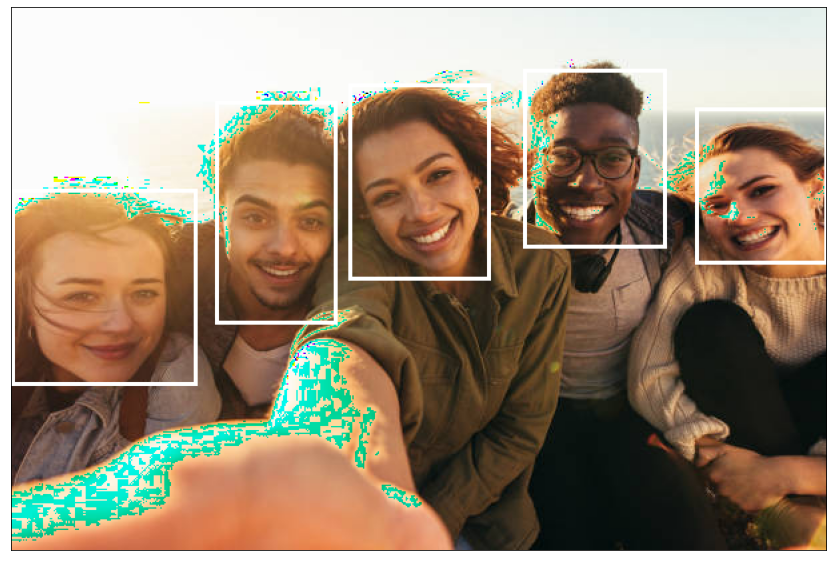

In [16]:
boxes = pred[0]['boxes'][pred[0]['scores'] > 0.9]
show(draw_bounding_boxes((obj['x']*256).to(dtype=torch.uint8), boxes, width=3))